In [2]:
using Flux, CUDA
using ProgressMeter
using Plots; plotlyjs()
using Random, Distributions
using CSV, DataFrames
using Images

In [228]:
# Data Preparation

rawDataFrame = CSV.read("DataCutP1.csv", DataFrame)
paramsNum = ncol(rawDataFrame)
xyRaw = Matrix(rawDataFrame)

function splitMatrix(mat, perc)
    @assert 0 <= perc <= 1
    ids = collect(axes(mat, 1))
    shuffle!(ids)
    sel = ids .<= size(mat, 1) .* perc
    return view(mat, sel, :), view(mat, .!sel, :)
end

xyTrain, xyTest = splitMatrix(xyRaw, 0.5)
xTrain, yTrain = xyTrain[:, 1:(paramsNum - 1)]', xyTrain[:, paramsNum]'
xTest, yTest = xyTest[:, 1:(paramsNum - 1)]', xyTest[:, paramsNum]'

([51.17379 75.76613 … 20.192173 114.61275; 0.8048641 1.5570319 … 1.1929562 1.5189338; … ; 1.7563983 3.8417335 … 0.57534254 0.107253104; 2.7926148 4.24938332 … 0.96608294 0.9070453039999999], [0.0 1.0 … 0.0 0.0])

In [275]:
model = Flux.Chain(
    Flux.Dense(9 => 256, relu),
    BatchNorm(256),
    Flux.Dense(256 => 8, relu),
    Flux.Dense(8 => 1, relu)
)
# loss(x, y) = - mean(model(x) .* log.(y))
loss(x, y) = Flux.Losses.crossentropy(model(x), y)
parameters = Flux.params(model)
learningRate = 0.01
optimiser = ADAM(learningRate)
data = [(xTrain, yTrain)]

1-element Vector{Tuple{LinearAlgebra.Adjoint{Float64, Matrix{Float64}}, LinearAlgebra.Adjoint{Float64, Vector{Float64}}}}:
 ([105.73519 94.56117 … 29.203876 101.697914; 1.2347435 0.9310388 … 1.1997063 0.79622513; … ; 0.5424858 9.007084 … 1.3052752 0.042001974; 3.187708 11.6173607 … 1.9697854000000001 0.392673574], [0.0 1.0 … 1.0 0.0])

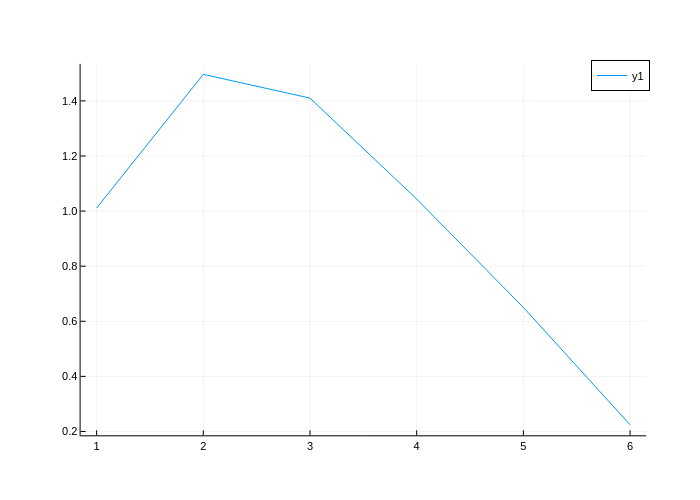

In [276]:
lossHistory = []
@showprogress for epoch in 1:100
    Flux.train!(loss, Flux.params(model), data, optimiser)
    currentLoss = loss(xTest, yTest)
    if currentLoss < 0
        break
    end
    append!(lossHistory, currentLoss)
end
plot(lossHistory)

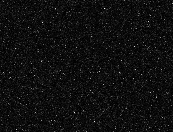

In [277]:
result = model(xTest)
maxRes = maximum(result)
minRes = minimum(result)
rawAns = (result .- minRes) ./ (maxRes - minRes)
displayImg = reshape(rawAns, 132, 173)
Gray.(displayImg)

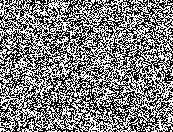

In [278]:
exReshape = reshape(yTest, 132, 173)
Gray.(exReshape)

In [268]:
roundRawAns = round.(rawAns)
points = 0
for i in 1:size(roundRawAns, 2)
    if roundRawAns[i] == yTest[i]
        points = points + 1
    end
end
accuracy = (points/size(roundRawAns, 2)) * 100

50.22771063233491